In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
import tensorflow.python.keras.engine
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *
from google.colab import drive

import keras.utils as image
#no containers


In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
### Constants ###
ROOT_DIR="/content/drive/My Drive"
DATA_DIR = "/content/drive/My Drive/Colab Notebooks/data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [ ]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 500
X_train shape: (2000, 64, 64, 3)


In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

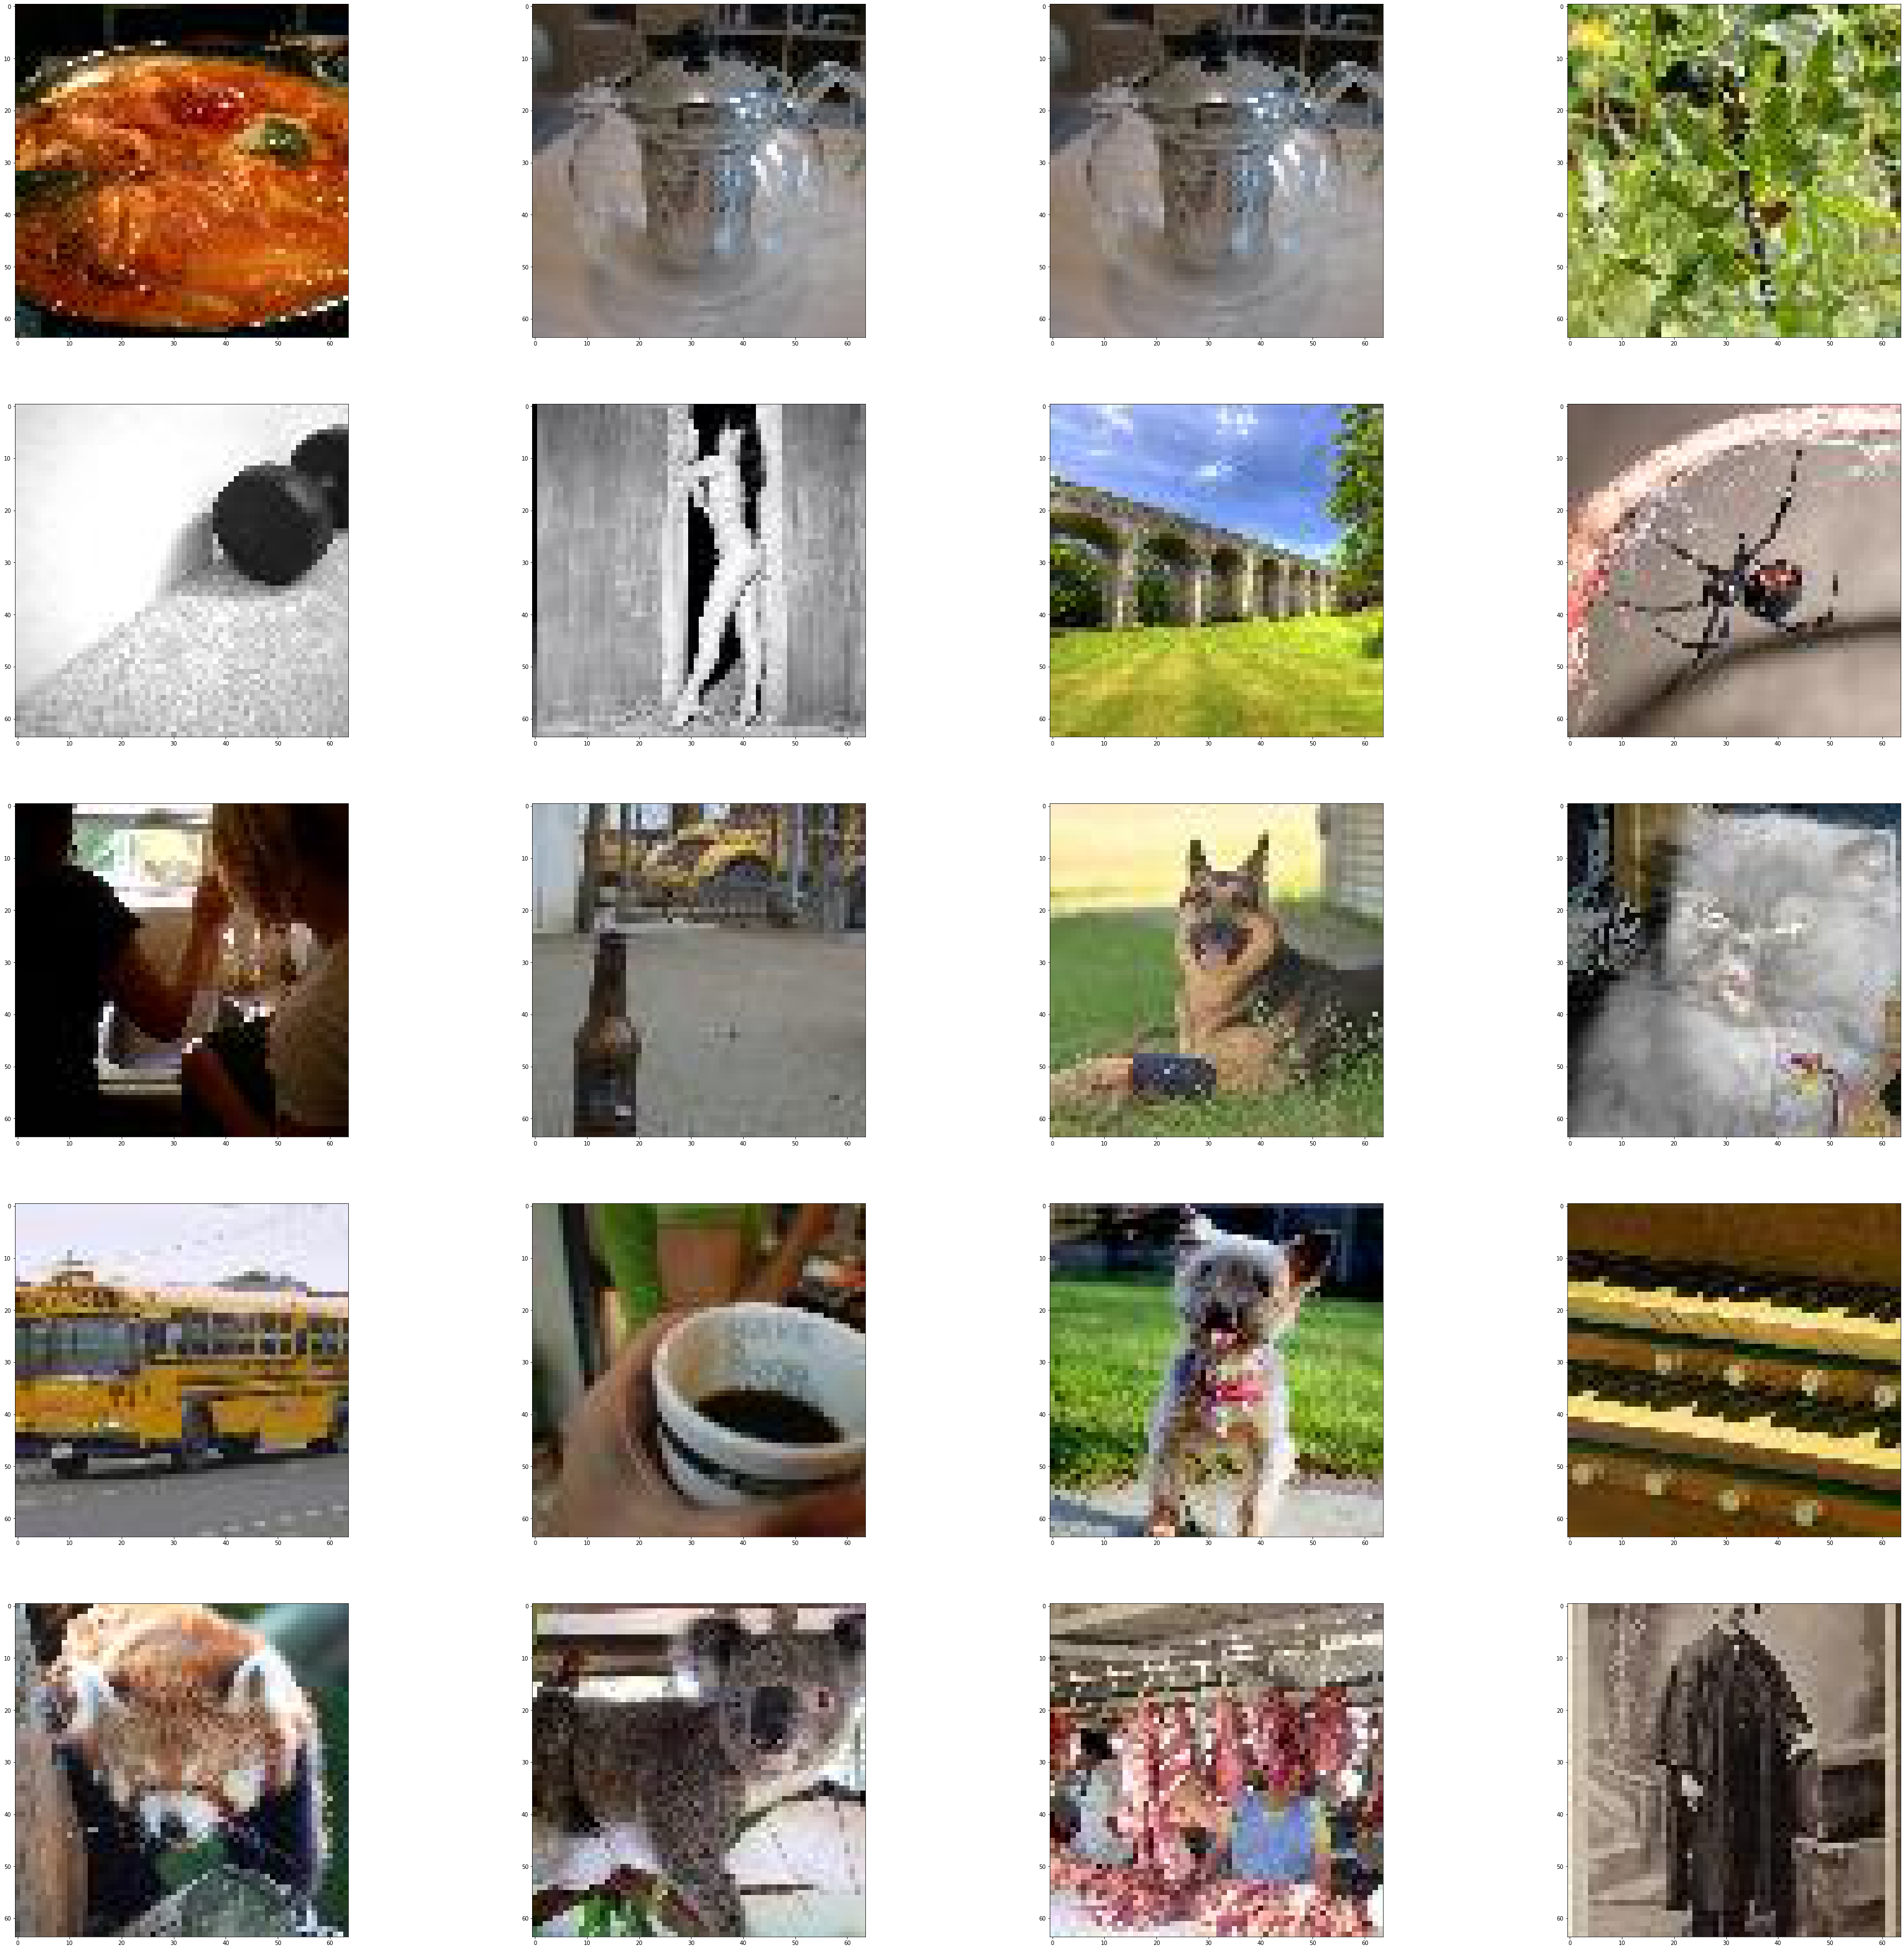

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(64, 64))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    #s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    #s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    
    #s_loss = rev_loss(s_true, s_pred)
    s_loss = beta * K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.summary()

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
NB_EPOCHS = 400
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
         
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C], y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


Epoch 1 | Batch:   0 of 1000. Loss AE  211575.59 | Loss Rev  106616.89:   3%|▎         | 1/32 [00:47<24:40, 47.77s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch:  32 of 1000. Loss AE  162208.41 | Loss Rev   72513.47:   6%|▋         | 2/32 [01:28<21:45, 43.50s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch:  64 of 1000. Loss AE  144559.00 | Loss Rev   64671.11:   9%|▉         | 3/32 [02:16<22:07, 45.79s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch:  96 of 1000. Loss AE  147154.02 | Loss Rev   75937.31:  12%|█▎        | 4/32 [02:59<20:44, 44.45s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 128 of 1000. Loss AE  142808.86 | Loss Rev   70673.56:  16%|█▌        | 5/32 [03:49<20:57, 46.58s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 160 of 1000. Loss AE  142433.41 | Loss Rev   69833.65:  19%|█▉        | 6/32 [04:32<19:37, 45.27s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 192 of 1000. Loss AE  140341.24 | Loss Rev   68573.91:  22%|██▏       | 7/32 [05:15<18:38, 44.73s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 224 of 1000. Loss AE  133684.75 | Loss Rev   63270.14:  25%|██▌       | 8/32 [05:58<17:38, 44.11s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 256 of 1000. Loss AE  137765.00 | Loss Rev   68215.91:  28%|██▊       | 9/32 [06:41<16:45, 43.70s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 288 of 1000. Loss AE  130581.19 | Loss Rev   63708.28:  31%|███▏      | 10/32 [07:24<15:57, 43.52s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 320 of 1000. Loss AE  126508.70 | Loss Rev   62025.77:  34%|███▍      | 11/32 [08:15<16:02, 45.84s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 352 of 1000. Loss AE  125437.05 | Loss Rev   61413.10:  38%|███▊      | 12/32 [08:59<15:04, 45.23s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 384 of 1000. Loss AE  123860.10 | Loss Rev   62251.19:  41%|████      | 13/32 [09:42<14:03, 44.40s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 416 of 1000. Loss AE  121574.17 | Loss Rev   62378.49:  44%|████▍     | 14/32 [10:24<13:06, 43.72s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 448 of 1000. Loss AE  118368.93 | Loss Rev   61117.50:  47%|████▋     | 15/32 [11:12<12:47, 45.17s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 480 of 1000. Loss AE  116158.61 | Loss Rev   59051.24:  50%|█████     | 16/32 [11:55<11:49, 44.34s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 512 of 1000. Loss AE  112665.27 | Loss Rev   57154.05:  53%|█████▎    | 17/32 [12:37<10:57, 43.81s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 544 of 1000. Loss AE  109398.73 | Loss Rev   55649.50:  56%|█████▋    | 18/32 [13:18<10:00, 42.92s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 576 of 1000. Loss AE  106036.25 | Loss Rev   53955.21:  59%|█████▉    | 19/32 [13:59<09:11, 42.43s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 608 of 1000. Loss AE  103579.40 | Loss Rev   52662.75:  62%|██████▎   | 20/32 [14:42<08:30, 42.57s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 640 of 1000. Loss AE  100984.02 | Loss Rev   51293.23:  66%|██████▌   | 21/32 [15:25<07:48, 42.62s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 672 of 1000. Loss AE   98486.71 | Loss Rev   49933.79:  69%|██████▉   | 22/32 [16:06<07:00, 42.05s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 704 of 1000. Loss AE   96457.36 | Loss Rev   48863.14:  72%|███████▏  | 23/32 [16:46<06:13, 41.52s/it]

1/1 [==============================] - 4s 4s/step


Epoch 1 | Batch: 736 of 1000. Loss AE   94352.80 | Loss Rev   47795.61:  75%|███████▌  | 24/32 [17:28<05:33, 41.73s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 768 of 1000. Loss AE   92389.06 | Loss Rev   46807.67:  78%|███████▊  | 25/32 [18:08<04:48, 41.27s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 800 of 1000. Loss AE   90448.04 | Loss Rev   45850.90:  81%|████████▏ | 26/32 [18:48<04:05, 40.87s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 832 of 1000. Loss AE   89046.02 | Loss Rev   45132.02:  84%|████████▍ | 27/32 [19:37<03:35, 43.18s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 864 of 1000. Loss AE   87402.77 | Loss Rev   44387.54:  88%|████████▊ | 28/32 [20:18<02:50, 42.60s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 896 of 1000. Loss AE   85804.33 | Loss Rev   43693.60:  91%|█████████ | 29/32 [21:01<02:07, 42.65s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 928 of 1000. Loss AE   84444.05 | Loss Rev   43082.44:  94%|█████████▍| 30/32 [21:44<01:25, 42.64s/it]

1/1 [==============================] - 3s 3s/step


Epoch 1 | Batch: 960 of 1000. Loss AE   83217.07 | Loss Rev   42601.32:  97%|█████████▋| 31/32 [22:34<00:44, 44.93s/it]

1/1 [==============================] - 1s 1s/step


Epoch 1 | Batch: 992 of 1000. Loss AE   80970.29 | Loss Rev   41487.34: 100%|██████████| 32/32 [22:47<00:00, 42.73s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch:   0 of 1000. Loss AE   52292.68 | Loss Rev   35090.58:   3%|▎         | 1/32 [00:42<22:06, 42.78s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch:  32 of 1000. Loss AE   47905.70 | Loss Rev   31982.12:   6%|▋         | 2/32 [01:23<20:43, 41.44s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch:  64 of 1000. Loss AE   47705.70 | Loss Rev   30831.18:   9%|▉         | 3/32 [02:05<20:13, 41.84s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch:  96 of 1000. Loss AE   47212.53 | Loss Rev   30344.77:  12%|█▎        | 4/32 [02:54<20:45, 44.47s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 128 of 1000. Loss AE   46444.81 | Loss Rev   29213.09:  16%|█▌        | 5/32 [03:36<19:43, 43.84s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 160 of 1000. Loss AE   45513.79 | Loss Rev   28111.09:  19%|█▉        | 6/32 [04:19<18:49, 43.44s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 192 of 1000. Loss AE   44918.23 | Loss Rev   27639.55:  22%|██▏       | 7/32 [05:02<18:00, 43.22s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 224 of 1000. Loss AE   44033.82 | Loss Rev   27141.58:  25%|██▌       | 8/32 [05:43<16:58, 42.44s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 256 of 1000. Loss AE   43963.08 | Loss Rev   27215.35:  28%|██▊       | 9/32 [06:33<17:13, 44.96s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 288 of 1000. Loss AE   43386.07 | Loss Rev   26713.28:  31%|███▏      | 10/32 [07:16<16:16, 44.36s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 320 of 1000. Loss AE   43300.32 | Loss Rev   26704.24:  34%|███▍      | 11/32 [07:58<15:17, 43.70s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 352 of 1000. Loss AE   43151.23 | Loss Rev   26554.24:  38%|███▊      | 12/32 [08:47<15:02, 45.13s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 384 of 1000. Loss AE   43079.73 | Loss Rev   26398.84:  41%|████      | 13/32 [09:30<14:04, 44.45s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 416 of 1000. Loss AE   42642.11 | Loss Rev   26114.39:  44%|████▍     | 14/32 [10:10<12:56, 43.14s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 448 of 1000. Loss AE   42847.77 | Loss Rev   26120.66:  47%|████▋     | 15/32 [10:52<12:08, 42.86s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 480 of 1000. Loss AE   42781.54 | Loss Rev   26121.84:  50%|█████     | 16/32 [11:34<11:21, 42.59s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 512 of 1000. Loss AE   42555.13 | Loss Rev   26020.33:  53%|█████▎    | 17/32 [12:16<10:36, 42.45s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 544 of 1000. Loss AE   42669.01 | Loss Rev   25988.96:  56%|█████▋    | 18/32 [12:59<09:55, 42.54s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 576 of 1000. Loss AE   42487.80 | Loss Rev   25828.06:  59%|█████▉    | 19/32 [13:41<09:12, 42.54s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 608 of 1000. Loss AE   42404.81 | Loss Rev   25735.79:  62%|██████▎   | 20/32 [14:23<08:29, 42.43s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 640 of 1000. Loss AE   42171.71 | Loss Rev   25582.64:  66%|██████▌   | 21/32 [15:04<07:39, 41.77s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 672 of 1000. Loss AE   42044.99 | Loss Rev   25516.57:  69%|██████▉   | 22/32 [15:46<07:00, 42.03s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 704 of 1000. Loss AE   41865.78 | Loss Rev   25419.28:  72%|███████▏  | 23/32 [16:28<06:18, 42.07s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 736 of 1000. Loss AE   41678.00 | Loss Rev   25344.99:  75%|███████▌  | 24/32 [17:11<05:36, 42.12s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 768 of 1000. Loss AE   41558.78 | Loss Rev   25333.61:  78%|███████▊  | 25/32 [17:53<04:54, 42.12s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 800 of 1000. Loss AE   41252.90 | Loss Rev   25076.20:  81%|████████▏ | 26/32 [18:43<04:27, 44.56s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 832 of 1000. Loss AE   40930.43 | Loss Rev   24796.41:  84%|████████▍ | 27/32 [19:25<03:39, 43.90s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 864 of 1000. Loss AE   40633.25 | Loss Rev   24495.34:  88%|████████▊ | 28/32 [20:08<02:53, 43.40s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 896 of 1000. Loss AE   40387.26 | Loss Rev   24214.37:  91%|█████████ | 29/32 [20:48<02:07, 42.59s/it]

1/1 [==============================] - 3s 3s/step


Epoch 2 | Batch: 896 of 1000. Loss AE   40387.26 | Loss Rev   24214.37:  91%|█████████ | 29/32 [21:25<02:12, 44.33s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-ee0319794215>", line 20, in <module>
    ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C], y=np.concatenate((batch_S, batch_C),axis=3)))
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2144, in train_on_batch
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 947, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-call

KeyboardInterrupt: ignored

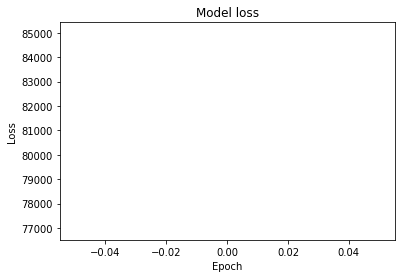

In [ ]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Save model
#autoencoder_model.save_weights('m/model.hdf5')

OSError: ignored

In [ ]:
# Load model
autoencoder_model.load_weights("/content/drive/My Drive/Colab Notebooks/models/mo.hdf5")

In [ ]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

32/32 [==============================] - 169s 5s/step


In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 6.864911
C error per pixel [0, 255]: 10.930705


AttributeError: ignored

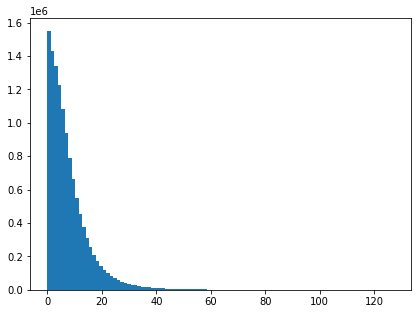

In [ ]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

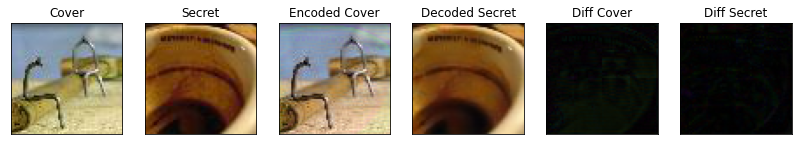

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()